In [1]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Using Gemini in Education

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/education/use_cases_for_education.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fgemini%2Fuse-cases%2Feducation%2Fuse_cases_for_education.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Run in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/use-cases/education/use_cases_for_education.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/education/use_cases_for_education.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>


| | |
|-|-|
|Author(s) | [Laurent Picard](https://github.com/PicardParis) |

## Overview

In this notebook, you will explore a variety of use cases enabled by Gemini models in the context of education.

### Gemini

Gemini is a family of generative AI models developed by Google DeepMind that is designed for multimodal use cases. The Gemini API gives you access to the Gemini 1.0 Pro Vision and Gemini 1.0 Pro models.

### Vertex AI Gemini API

The Vertex AI Gemini API provides a unified interface for interacting with Gemini models. There are currently two models available in the Gemini API:

- **Gemini 1.0 Pro model** (`gemini-1.0-pro`): Designed to handle natural language tasks, multiturn text and code chat, and code generation.
- **Gemini 1.0 Pro Vision model** (`gemini-1.0-pro-vision`): Supports multimodal prompts. You can include text, images, and video in your prompt requests and get text or code responses.

For more information, see the [Generative AI on Vertex AI](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/overview) documentation.


### Objectives

The main objective of this notebook is to demonstrate a variety of educational use cases that can benefit from the Gemini models.

The steps performed include:

- Installing the Python SDK
- Using the Vertex AI Gemini API
  - Using a text model (`gemini-1.0-pro`)
    - Reasoning at different levels
    - Reasoning on text
    - Reasoning on numbers
  - Using a multimodal model (`gemini-1.0-pro-vision`)
    - Reasoning on a single image
    - Reasoning on multiple images
    - Reasoning on a video


### Costs

This tutorial uses billable components of Google Cloud:

- Vertex AI

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.


## Getting Started


### Install Vertex AI SDK


In [2]:
! pip3 install --upgrade --user google-cloud-aiplatform

### Restart current runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

In [3]:
# Restart kernel after installs so that your environment can access the new packages
import IPython
import time

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>



### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the following cell to authenticate your environment. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).


In [1]:
import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

### Define Google Cloud project information and initialize Vertex AI

Initialize the Vertex AI SDK for Python for your project:

In [2]:
# Define project information
PROJECT_ID = "qwiklabs-gcp-03-89ee8aff8963"  # @param {type:"string"}
LOCATION = "us-east4"  # @param {type:"string"}

# Initialize Vertex AI
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

### Import libraries


In [3]:
from vertexai.generative_models import (
    GenerationConfig,
    GenerationResponse,
    GenerativeModel,
    Image,
    Part,
)

### Define helper functions

Define some helper functions to load and display images.


In [4]:
import http.client
import io
import typing
import urllib.request

import IPython.display
from PIL import Image as PIL_Image
from PIL import ImageOps as PIL_ImageOps

Contents = str | list[str | Image | Part]


def generate_content(
    model: GenerativeModel,
    contents: Contents,
    temperature: float = 0.0,
    top_p: float = 0.0,
    top_k: int = 1,
) -> list[GenerationResponse]:
    """Call the Vertex AI Gemini API.

    Default parameters have low randomness in this notebook for consistency across calls.
    """
    generation_config = GenerationConfig(
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
        candidate_count=1,
        max_output_tokens=2048,
    )

    responses = model.generate_content(
        contents,
        generation_config=generation_config,
        stream=True,
    )

    # In streaming mode, multiple GenerationResponse can be generated
    # In unary (non-streaming) mode, a single GenerationResponse is returned
    return [responses] if isinstance(responses, GenerationResponse) else list(responses)


def print_contents(contents: Contents):
    """Print the full contents for ease of readability."""
    if not isinstance(contents, list):
        contents = [contents]

    print(" Contents ".center(80, "-"))
    for content in contents:
        if display_content_as_image(content):
            continue
        if display_content_as_video(content):
            continue
        print(content)


def display_content_as_image(content: str | Image | Part) -> bool:
    if not isinstance(content, Image):
        return False
    display_image(content)
    return True


def display_content_as_video(content: str | Image | Part) -> bool:
    if not isinstance(content, Part):
        return False
    part = typing.cast(Part, content)
    file_path = part.file_data.file_uri.removeprefix("gs://")
    video_url = f"https://storage.googleapis.com/{file_path}"
    IPython.display.display(IPython.display.Video(video_url, width=600))
    return True


def print_responses(responses: list[GenerationResponse], as_markdown: bool = True):
    """Print the full responses."""
    # Consolidate the text
    text = "".join(
        part.text
        for response in responses
        for part in response.candidates[0].content.parts
    )
    # Remove potential leading/trailing spaces
    text = text.strip()

    print(" Start of responses ".center(80, "-"))
    if as_markdown:
        IPython.display.display(IPython.display.Markdown(text))
    else:
        print(text)
    print(" End of responses ".center(80, "-"))
    print("")


def display_image(image: Image, max_width: int = 600, max_height: int = 350):
    pil_image = typing.cast(PIL_Image.Image, image._pil_image)
    if pil_image.mode != "RGB":
        # Modes such as RGBA are not yet supported by all Jupyter environments
        pil_image = pil_image.convert("RGB")

    image_width, image_height = pil_image.size
    if max_width < image_width or max_height < image_height:
        # Resize to display a smaller notebook image
        pil_image = PIL_ImageOps.contain(pil_image, (max_width, max_height))

    display_image_compressed(pil_image)


def display_image_compressed(pil_image: PIL_Image.Image):
    """Display the image in a compressed format to reduce the notebook size."""
    image_io = io.BytesIO()
    pil_image.save(image_io, "jpeg", quality=80, optimize=True)
    image_bytes = image_io.getvalue()
    ipython_image = IPython.display.Image(image_bytes)
    IPython.display.display(ipython_image)


def load_image_from_url(image_url: str) -> Image:
    image_bytes = get_image_bytes_from_url(image_url)
    return Image.from_bytes(image_bytes)


def get_image_bytes_from_url(image_url: str) -> bytes:
    with urllib.request.urlopen(image_url) as response:
        response = typing.cast(http.client.HTTPResponse, response)
        image_bytes = response.read()
    return image_bytes

## Use the Gemini 1.0 Pro model

The Gemini 1.0 Pro (`gemini-1.0-pro`) model is designed to handle natural language tasks, multiturn text and code chat, and code generation.


### Load the Gemini 1.0 Pro model


In [5]:
model = GenerativeModel("gemini-1.0-pro")

### Reasoning at different levels


You can ask for direct answers:


In [6]:
contents = """
What happened to the dinosaurs? When?
Explain simply in one sentence.
"""
responses = generate_content(model, contents)
print_contents(contents)
print_responses(responses)

----------------------------------- Contents -----------------------------------

What happened to the dinosaurs? When?
Explain simply in one sentence.

------------------------------ Start of responses ------------------------------


The dinosaurs went extinct about 66 million years ago, likely due to a large asteroid impact that caused major climate changes.

------------------------------- End of responses -------------------------------



… as well as for more nuanced answers:


In [7]:
contents = """
Are we 100% sure about what happened to the dinosaurs?
If not, detail the current main hypotheses.
"""
responses = generate_content(model, contents)
print_contents(contents)
print_responses(responses)

----------------------------------- Contents -----------------------------------

Are we 100% sure about what happened to the dinosaurs?
If not, detail the current main hypotheses.

------------------------------ Start of responses ------------------------------


## The Great Dinosaur Mystery: What Really Happened?

While the extinction of the dinosaurs is one of the most well-studied events in Earth's history, there are still some lingering mysteries surrounding it. While the Chicxulub asteroid impact is widely accepted as the main culprit, other factors may have played a role. Let's delve into the current main hypotheses:

**1. The Chicxulub Impact:**

This is the prevailing theory, supported by overwhelming evidence. Around 66 million years ago, a massive asteroid, estimated to be 10-15 kilometers wide, slammed into Earth near the Yucatán Peninsula. The impact triggered a chain reaction of catastrophic events:

* **Global devastation:** The impact released immense energy, equivalent to billions of atomic bombs, causing widespread wildfires, earthquakes, and tsunamis.
* **Dust and debris:** The impact ejected colossal amounts of dust and debris into the atmosphere, blocking sunlight and causing a global winter that lasted for years.
* **Acid rain and climate change:** The dust and debris also triggered acid rain and disrupted global climate patterns, leading to extreme temperature fluctuations and widespread ecological collapse.

The Chicxulub impact is believed to have directly killed many dinosaurs and other organisms. The prolonged darkness and harsh environmental conditions further decimated the survivors, leading to the extinction of over 75% of life on Earth, including the dinosaurs.

**2. Volcanic Activity:**

The Deccan Traps in India, a massive volcanic province, erupted over a period of millions of years around the same time as the Chicxulub impact. These eruptions released vast amounts of greenhouse gases, potentially contributing to global warming and further stressing the dinosaurs' already fragile ecosystem.

**3. Combined Effects:**

Some scientists believe that a combination of the Chicxulub impact and Deccan Traps eruptions may have been necessary to drive the dinosaurs to extinction. The impact could have weakened the dinosaurs, making them more vulnerable to the long-term effects of volcanic activity and climate change.

**4. Other Contributing Factors:**

Other factors, such as sea level changes, disease outbreaks, and changes in ocean circulation, may have also played a role in the dinosaurs' demise.

**5. Ongoing Research:**

The debate about the exact cause of the dinosaur extinction continues. New research and discoveries are constantly shedding light on this complex event. Scientists are exploring the potential role of various factors and refining their understanding of the impact's long-term consequences.

**Conclusion:**

While the Chicxulub impact is the most likely culprit behind the dinosaur extinction, the possibility of other contributing factors remains open. Ongoing research continues to unravel the mysteries surrounding this pivotal event in Earth's history.

------------------------------- End of responses -------------------------------



You can ask for simple answers:


In [8]:
contents = """
Explain why it's winter here in France and summer in Australia.
I'm a kid. Answer in 3 simple key points.
"""
responses = generate_content(model, contents)
print_contents(contents)
print_responses(responses)

----------------------------------- Contents -----------------------------------

Explain why it's winter here in France and summer in Australia.
I'm a kid. Answer in 3 simple key points.

------------------------------ Start of responses ------------------------------


## Why it's winter in France and summer in Australia:

1. **Earth is tilted:** Our planet isn't perfectly upright, it's tilted at an angle. This means different parts of Earth receive more or less direct sunlight throughout the year.
2. **Seasons:** As Earth orbits the sun, the tilted angle causes different hemispheres to experience different seasons. Right now, the Northern Hemisphere (where France is) is tilted away from the sun, receiving less direct sunlight, making it winter. Meanwhile, the Southern Hemisphere (where Australia is) is tilted towards the sun, receiving more direct sunlight, making it summer.
3. **Sun's warmth:** Direct sunlight brings warmth. So, when a region gets more direct sunlight, it experiences warmer temperatures and summer. When a region gets less direct sunlight, it experiences colder temperatures and winter.

Remember, it's all about Earth's tilt and how it affects the amount of sunlight each region receives!

------------------------------- End of responses -------------------------------



… or for more detailed answers:


In [9]:
contents = """
Explain why we have tides.
I'm an adult. Provide a detailed answer using bullet points.
"""
responses = generate_content(model, contents)
print_contents(contents)
print_responses(responses)

----------------------------------- Contents -----------------------------------

Explain why we have tides.
I'm an adult. Provide a detailed answer using bullet points.

------------------------------ Start of responses ------------------------------


## The Tides: A Dance of Gravity and Motion

The rhythmic rise and fall of ocean waters, known as tides, are a captivating display of nature's forces. This phenomenon, experienced twice daily in most coastal regions, is primarily driven by the gravitational pull of the moon and, to a lesser extent, the sun. Let's delve deeper into the intricate interplay that governs this mesmerizing dance of the sea:

**The Moon's Magnetic Grip:**

* **Gravitational Tug:** The moon's gravitational pull exerts a stronger influence on the side of the Earth facing it, causing the water to bulge towards the moon. This creates a high tide on the side closest to the moon.
* **Centrifugal Force:** Simultaneously, the Earth and the moon are in constant rotation around their common center of mass. This rotation creates an outward centrifugal force that counteracts the moon's pull, resulting in a high tide on the opposite side of the Earth as well.
* **Resulting Bulges:** These two bulges of water, one facing the moon and the other on the opposite side, are the high tides. The areas between these bulges experience low tides, where the water level is at its lowest.

**The Sun's Subtle Sway:**

* **Gravitational Influence:** While the moon's gravitational pull is the primary driver of tides, the sun also plays a role. The sun's gravitational force, though weaker than the moon's, still contributes to the tidal bulges.
* **Combined Effect:** When the sun and moon are aligned (during new and full moon phases), their combined gravitational pull creates stronger high tides known as spring tides. Conversely, when the sun and moon are at right angles to each other (during first and third quarter phases), their opposing pulls result in weaker high tides called neap tides.

**Earth's Rotation and Local Factors:**

* **Earth's Spin:** The Earth's rotation further influences the timing and height of tides. As the Earth rotates, the tidal bulges move across different locations, creating the twice-daily high and low tides observed in most coastal areas.
* **Local Geography:** The shape of coastlines, ocean basins, and underwater features can significantly impact the height and timing of tides in specific regions. For instance, bays and estuaries often experience amplified tidal ranges due to their funnel-like shape.

**A Dynamic Equilibrium:**

The interplay of these forces – the moon's and sun's gravity, Earth's rotation, and local geography – creates a complex and dynamic system that governs the tides. This intricate dance of the sea not only shapes our coastlines but also influences marine life, coastal ecosystems, and even human activities like fishing and navigation.

------------------------------- End of responses -------------------------------



You can ask closed questions:


In [10]:
contents = """
When were the previous and penultimate leap years?
List 3 international competitions that took place during the penultimate one.
Detail dates, cities, and venues.
"""
responses = generate_content(model, contents)
print_contents(contents)
print_responses(responses)

----------------------------------- Contents -----------------------------------

When were the previous and penultimate leap years?
List 3 international competitions that took place during the penultimate one.
Detail dates, cities, and venues.

------------------------------ Start of responses ------------------------------


## Previous and Penultimate Leap Years

The previous leap year was **2020**. 

The penultimate leap year was **2016**.

## International Competitions in 2016

Here are three international competitions that took place during the penultimate leap year, 2016:

**1. Summer Olympics**

* Dates: August 5th - 21st, 2016
* City: Rio de Janeiro, Brazil
* Venue: Various venues across the city, including the Maracanã Stadium and the Olympic Aquatics Stadium.

**2. UEFA European Championship**

* Dates: June 10th - July 10th, 2016
* City: Various cities across France
* Venue: Various stadiums across the country, including the Stade de France and the Parc des Princes.

**3. Paralympic Games**

* Dates: September 7th - 18th, 2016
* City: Rio de Janeiro, Brazil
* Venue: Various venues across the city, including the Maracanã Stadium and the Olympic Aquatics Stadium.

------------------------------- End of responses -------------------------------



… as well as questions that are more open:


In [11]:
contents = """
What came first, the chicken or the egg? Explain from 3 different perspectives.
What do we call a "chicken and egg" problem? Give 1 example that can occur in education.
"""
responses = generate_content(model, contents)
print_contents(contents)
print_responses(responses)

----------------------------------- Contents -----------------------------------

What came first, the chicken or the egg? Explain from 3 different perspectives.
What do we call a "chicken and egg" problem? Give 1 example that can occur in education.

------------------------------ Start of responses ------------------------------


## The Chicken or the Egg: A Three-Part Perspective

The age-old question of "which came first, the chicken or the egg?" has puzzled philosophers and scientists for centuries. Here's a look at this conundrum from three different perspectives:

**1. Evolutionary Biology:** From an evolutionary standpoint, the egg predates the chicken. The ancestors of modern chickens were dinosaurs that laid eggs long before the evolution of the first true chicken. Over millions of years, these dinosaur eggs gradually evolved into the eggs we associate with chickens today. 

**2. Genetics:** From a genetic perspective, the chicken also came after the egg. The genetic code for a chicken is contained within the egg, and this code must have existed before the chicken itself could develop. Therefore, the egg, containing the genetic blueprint for the chicken, must have come first.

**3. Philosophy:** Philosophically, the question becomes more complex. Some argue that the concept of "first" implies a linear progression, which may not be applicable in this case. The chicken and the egg could be seen as two parts of a continuous cycle, with each element being necessary for the existence of the other.

## The "Chicken and Egg" Problem: A Catch-22 Situation

A "chicken and egg" problem refers to a situation where two things are interdependent, creating a Catch-22 scenario. Progress is impossible because each element requires the other to exist first.

## Example in Education: The Internship Dilemma

A common example of a "chicken and egg" problem in education is the internship dilemma. Many internships require applicants to have prior work experience, but gaining work experience often requires completing an internship. This creates a Catch-22 situation for students, who need the internship to gain experience but cannot get the internship without experience.

This problem can be addressed by offering entry-level internships specifically designed for students with little or no prior experience. Additionally, universities can partner with companies to create internship programs that provide students with the necessary skills and experience to qualify for more advanced internships in the future.

------------------------------- End of responses -------------------------------



### Reasoning on text


You can summarize and translate text:


In [12]:
contents = """
Summarize the following text in three sentences, in English, only using the text.

TEXT:
- Les hommes naissent et demeurent libres et égaux en droits. Les distinctions sociales ne peuvent être fondées que sur l'utilité commune.
- Le but de toute association politique est la conservation des droits naturels et imprescriptibles de l'homme. Ces droits sont la liberté, la propriété, la sûreté et la résistance à l'oppression.
- Le principe de toute souveraineté réside essentiellement dans la Nation. Nul corps, nul individu ne peut exercer d'autorité qui n'en émane expressément.
- La liberté consiste à pouvoir faire tout ce qui ne nuit pas à autrui : ainsi, l'exercice des droits naturels de chaque homme n'a de bornes que celles qui assurent aux autres membres de la société la jouissance de ces mêmes droits. Ces bornes ne peuvent être déterminées que par la loi.
La loi n'a le droit de défendre que les actions nuisibles à la société. Tout ce qui n'est pas défendu par la loi ne peut être empêché, et nul ne peut être contraint à faire ce qu'elle n'ordonne pas.
- La loi est l'expression de la volonté générale. Tous les citoyens ont droit de concourir personnellement ou par leurs représentants à sa formation. Elle doit être la même pour tous, soit qu'elle protège, soit qu'elle punisse. Tous les citoyens, étant égaux à ses yeux, sont également admissibles à toutes dignités, places et emplois publics, selon leur capacité et sans autre distinction que celle de leurs vertus et de leurs talents.
- Nul homme ne peut être accusé, arrêté ou détenu que dans les cas déterminés par la loi et selon les formes qu'elle a prescrites. Ceux qui sollicitent, expédient, exécutent ou font exécuter des ordres arbitraires doivent être punis ; mais tout citoyen appelé ou saisi en vertu de la loi doit obéir à l'instant ; il se rend coupable par la résistance.
- La loi ne doit établir que des peines strictement et évidemment nécessaires, et nul ne peut être puni qu'en vertu d'une loi établie et promulguée antérieurement au délit, et légalement appliquée.
Tout homme étant présumé innocent jusqu'à ce qu'il ait été déclaré coupable, s'il est jugé indispensable de l'arrêter, toute rigueur qui ne serait pas nécessaire pour s'assurer de sa personne doit être sévèrement réprimée par la loi.
- Nul ne doit être inquiété pour ses opinions, même religieuses, pourvu que leur manifestation ne trouble pas l'ordre public établi par la loi.

SUMMARY:
-
"""
responses = generate_content(model, contents)
print_contents(contents)
print_responses(responses)

----------------------------------- Contents -----------------------------------

Summarize the following text in three sentences, in English, only using the text.

TEXT:
- Les hommes naissent et demeurent libres et égaux en droits. Les distinctions sociales ne peuvent être fondées que sur l'utilité commune.
- Le but de toute association politique est la conservation des droits naturels et imprescriptibles de l'homme. Ces droits sont la liberté, la propriété, la sûreté et la résistance à l'oppression.
- Le principe de toute souveraineté réside essentiellement dans la Nation. Nul corps, nul individu ne peut exercer d'autorité qui n'en émane expressément.
- La liberté consiste à pouvoir faire tout ce qui ne nuit pas à autrui : ainsi, l'exercice des droits naturels de chaque homme n'a de bornes que celles qui assurent aux autres membres de la société la jouissance de ces mêmes droits. Ces bornes ne peuvent être déterminées que par la loi.
La loi n'a le droit de défendre que les actions nu

## Summary of the Text in Three Sentences:

1. The Declaration of the Rights of Man and of the Citizen asserts that all individuals are born free and equal, with inherent rights to liberty, property, security, and resistance to oppression.
2. Sovereignty resides in the nation, and the law, which is the expression of the general will, protects these rights and ensures their equal enjoyment by all citizens.
3. Justice demands that individuals be punished only for actions harmful to society, with due process and presumption of innocence, and that freedom of opinion be respected as long as it does not disrupt public order.

------------------------------- End of responses -------------------------------



… as well as ask for ideas:


In [13]:
contents = """
Provide an outline in 5 key points for a "chocolate in the world" presentation.
One part must be about its origin in Mexico (my teacher has family there).
The last one will be a tasting with everybody in the classroom.
"""

# For more creative/diverse answers, let's increase the level of randomness.
# Successive requests will likely return different responses.
temperature = 0.7
top_p = 0.8
top_k = 40

responses = generate_content(model, contents, temperature, top_p, top_k)

print_contents(contents)
print_responses(responses)

----------------------------------- Contents -----------------------------------

Provide an outline in 5 key points for a "chocolate in the world" presentation.
One part must be about its origin in Mexico (my teacher has family there).
The last one will be a tasting with everybody in the classroom.

------------------------------ Start of responses ------------------------------


## Chocolate in the World: A Delicious Journey

**1. The Alluring Allure of Chocolate:**

* Begin with a captivating introduction about chocolate's global popularity and its irresistible allure. 
* Briefly discuss its historical significance as a prized commodity and cultural symbol.

**2. A Mesoamerican Marvel: The Origins of Chocolate in Mexico:**

* Dive into the fascinating history of chocolate in Mexico, highlighting its deep cultural roots.
* Explain how the ancient Mayans and Aztecs cultivated cacao beans and prepared them into a bitter, frothy drink.
* Share intriguing details about the cultural significance of chocolate in these civilizations, including its use in religious ceremonies and as a form of currency.
* **Connect with your teacher's personal connection:** Briefly mention your teacher's family ties to Mexico and how they might have experienced the unique role of chocolate in Mexican culture.

**3. From the Americas to the World: The Global Expansion of Chocolate:**

* Trace the journey of chocolate from the Americas to Europe, explaining how Spanish conquistadors introduced it to the Old World.
* Discuss how chocolate was initially met with skepticism but eventually embraced by European society, evolving into a sweet treat enjoyed by all.
* Briefly explore the spread of chocolate cultivation to other parts of the world, including Africa and Asia.

**4. The Science of Chocolate: From Bean to Bar:**

* Provide a simplified explanation of the chocolate-making process, from harvesting the cacao pods to transforming them into the delectable treat we know and love.
* Briefly discuss the different types of chocolate (dark, milk, white) and the impact of processing on their flavor profiles.
* Consider incorporating visuals like pictures or videos to illustrate the different stages of chocolate production.

**5. A Chocolatey Conclusion: Tasting and Reflection:**

* Conclude the presentation with a fun and interactive chocolate tasting session for the entire class.
* Provide a variety of different chocolate samples, allowing everyone to experience the diverse flavors and textures.
* Encourage reflection and discussion on personal preferences, cultural associations with chocolate, and its potential impact on health and sustainability.

**Bonus:**

* Consider incorporating multimedia elements throughout the presentation, such as images, videos, and music, to enhance engagement and understanding.
* Encourage audience participation by asking questions and inviting personal anecdotes about chocolate experiences.
* Leave the audience with a lasting impression of chocolate's rich history, global significance, and delicious diversity.

------------------------------- End of responses -------------------------------



You can also ask for text corrections:

Below, you can provide some examples of expected responses (i.e. few-shot prompting) so that the model can understand what kind of response you are expecting.


In [14]:
contents = """
I'm a non-native English speaker.
Check whether the following sentences are correct.
When incorrect, provide a correction and an explanation.
Use the same structure as in the given examples.

EXAMPLES:
- **Hi!**
  - Status: ✔️
- **Your my best freind!**
  - Status: ❌
  - Correction: **You're my best friend!**
  - Explanation:
    - "**Your**" is incorrect. It seems that you meant "You're", which is the short form of "You are".
    - "**freind**" is misspelled. The correct spelling is "**friend**".

SENTENCES:
- They're twins, isn't it?
- I assisted to the meeting.
- You received important informations.
- I digged a hole in the ice and saw lots of fishes.
- That's all folks!
"""
responses = generate_content(model, contents)
print_contents(contents)
print_responses(responses)

----------------------------------- Contents -----------------------------------

I'm a non-native English speaker.
Check whether the following sentences are correct.
When incorrect, provide a correction and an explanation.
Use the same structure as in the given examples.

EXAMPLES:
- **Hi!**
  - Status: ✔️
- **Your my best freind!**
  - Status: ❌
  - Correction: **You're my best friend!**
  - Explanation:
    - "**Your**" is incorrect. It seems that you meant "You're", which is the short form of "You are".
    - "**freind**" is misspelled. The correct spelling is "**friend**".

SENTENCES:
- They're twins, isn't it?
- I assisted to the meeting.
- You received important informations.
- I digged a hole in the ice and saw lots of fishes.
- That's all folks!

------------------------------ Start of responses ------------------------------


## Sentence Corrections:

**1. They're twins, isn't it?**

- **Status:** ❌
- **Correction:** They're twins, **aren't they?**
- **Explanation:** The question tag should be "aren't they?" to match the subject "They're".

**2. I assisted to the meeting.**

- **Status:** ❌
- **Correction:** I **attended** the meeting.
- **Explanation:** "Assisted" is not the correct verb for attending a meeting. "Attended" is the appropriate choice.

**3. You received important informations.**

- **Status:** ❌
- **Correction:** You received **important information**.
- **Explanation:** "Informations" is not a standard English word. The singular form "information" should be used.

**4. I digged a hole in the ice and saw lots of fishes.**

- **Status:** ❌
- **Correction:** I **dug** a hole in the ice and saw **lots of fish**.
- **Explanation:** 
    - "Digged" is the past tense of "dig", but the past participle is "dug".
    - "Fishes" is the plural form of "fish", but it is uncountable in this context.

**5. That's all folks!**

- **Status:** ✔️
- **Explanation:** This sentence is grammatically correct and idiomatic.

------------------------------- End of responses -------------------------------



… as well as ask for elaborate tasks on text and languages:


In [15]:
contents = """
Translate the text into the following languages.

TEXT:
Hello folks! I hope you're all doing well. Let's get this workshop started!
We'll stick to English because, actually, I can't speak all those languages.

LANGUAGES:
German, French, Greek, Bulgarian, Japanese
"""
responses = generate_content(model, contents)
print_contents(contents)
print_responses(responses)

----------------------------------- Contents -----------------------------------

Translate the text into the following languages.

TEXT:
Hello folks! I hope you're all doing well. Let's get this workshop started!
We'll stick to English because, actually, I can't speak all those languages.

LANGUAGES:
German, French, Greek, Bulgarian, Japanese

------------------------------ Start of responses ------------------------------


## Translations:

**German:**

Hallo zusammen! Ich hoffe, es geht euch allen gut. Lasst uns diesen Workshop beginnen!
Wir bleiben beim Englischen, weil ich all diese Sprachen nicht sprechen kann.

**French:**

Bonjour à tous ! J'espère que vous allez tous bien. Commençons cet atelier !
Nous allons nous en tenir à l'anglais car, en fait, je ne peux pas parler toutes ces langues.

**Greek:**

Γεια σας όλοι! Ελπίζω να είστε όλοι καλά. Ας ξεκινήσουμε αυτό το εργαστήριο!
Θα μείνουμε στα Αγγλικά γιατί, στην πραγματικότητα, δεν μπορώ να μιλήσω όλες αυτές τις γλώσσες.

**Bulgarian:**

Здравейте на всички! Надявам се, че всички сте добре. Нека започнем този семинар!
Ще се придържаме към английския, защото всъщност не мога да говоря всички тези езици.

**Japanese:**

皆さん、こんにちは！お元気でお過ごしでしょうか。このワークショップを始めましょう！
実は、私はこれらの言語をすべて話すことができないので、英語で進めさせていただきます。

------------------------------- End of responses -------------------------------



In [16]:
contents = """
I'm a non-native English speaker and made mistakes in the following sentences.
Guess my native language.
Explain why these are typical mistakes.
If there are several possibilities, here is a hint: I like cheese.

SENTENCES:
- They are twin sisters, isn't it?
- I assisted to the meeting.
- I saw lots of fishes.
"""
responses = generate_content(model, contents)
print_contents(contents)
print_responses(responses)

----------------------------------- Contents -----------------------------------

I'm a non-native English speaker and made mistakes in the following sentences.
Guess my native language.
Explain why these are typical mistakes.
If there are several possibilities, here is a hint: I like cheese.

SENTENCES:
- They are twin sisters, isn't it?
- I assisted to the meeting.
- I saw lots of fishes.

------------------------------ Start of responses ------------------------------


## Analyzing your sentences:

**1. They are twin sisters, isn't it?**

* **Mistake:** The subject-verb agreement is incorrect. "They" is plural, but the verb "is" is singular.
* **Typical mistake for:** Speakers of languages with different subject-verb agreement rules, such as Romance languages (Spanish, French, Italian) or Slavic languages (Russian, Polish, Czech). In these languages, the verb form often stays the same regardless of the subject's number.

**2. I assisted to the meeting.**

* **Mistake:** The verb "assist" is usually followed by the preposition "at" instead of "to."
* **Typical mistake for:** Speakers of languages where the equivalent verb requires a different preposition, such as German ("teilnehmen an"), French ("assister à"), or Spanish ("asistir a").

**3. I saw lots of fishes.**

* **Mistake:** The noun "fish" is uncountable and doesn't take a plural form. We say "lots of fish," not "fishes."
* **Typical mistake for:** Speakers of languages that distinguish between countable and uncountable nouns differently, such as Japanese, Korean, or Hungarian. In these languages, many nouns that are uncountable in English have plural forms.

## Guessing your native language:

Based on the mistakes you made, it's likely that your native language is one of the following:

* **Romance languages:** The subject-verb agreement error and the use of "to" with "assist" are common mistakes for speakers of Romance languages.
* **Slavic languages:** The subject-verb agreement error and the use of "to" with "assist" can also be typical mistakes for speakers of Slavic languages.
* **German:** The use of "to" with "assist" is a common mistake for German speakers.

However, the use of "fishes" instead of "fish" could also point to other languages, such as Japanese or Korean. 

**With the additional hint that you like cheese, my guess is that your native language is French.** This is because cheese plays a significant role in French culture and cuisine, and the mistakes you made are commonly observed among French speakers learning English.

Of course, this is just an educated guess based on the limited information available. If you'd like me to refine my guess, please provide more information about your language background or interests.

------------------------------- End of responses -------------------------------



### Reasoning on numbers


> Note: Like any LLM, Gemini generates plausible-sounding outputs, but may still hallucinate. Depending on inputs and parameters, outputs can be inaccurate, including math operations. As a best practice, you may want to consider prompting the LLM with step-by-step instructions to reduce hallucinations, or use a calculator library rather than an LLM.

You can ask about real life problems:


In [17]:
contents = """
Patricia is a good runner and runs at an average 12 km/h.
- On Monday, she ran for 1.5 hour. What distance did she run?
- On Tuesday, she ran for 21 km. How long did she run?
- On Wednesday, she ran for 150 minutes. What distance did she run?
- Next, she plans to do a marathon (42 km). How long should it take?
- To complete a marathon in 3 hours, how much faster does she need to run?

Detail the answers step by step.
"""
responses = generate_content(model, contents)
print_contents(contents)
print_responses(responses)

----------------------------------- Contents -----------------------------------

Patricia is a good runner and runs at an average 12 km/h.
- On Monday, she ran for 1.5 hour. What distance did she run?
- On Tuesday, she ran for 21 km. How long did she run?
- On Wednesday, she ran for 150 minutes. What distance did she run?
- Next, she plans to do a marathon (42 km). How long should it take?
- To complete a marathon in 3 hours, how much faster does she need to run?

Detail the answers step by step.

------------------------------ Start of responses ------------------------------


## Patricia's Running Performance:

### Monday:

* **Distance:** 1.5 hours * 12 km/h = 18 km
* **Calculation:** We multiply the time (1.5 hours) by her average speed (12 km/h) to find the total distance covered.

### Tuesday:

* **Time:** 21 km / 12 km/h = 1.75 hours
* **Calculation:** We divide the total distance (21 km) by her average speed (12 km/h) to find the time taken.

### Wednesday:

* **Distance:** 150 minutes * (1 hour / 60 minutes) * 12 km/h = 30 km
* **Calculation:** We first convert minutes to hours (150 minutes / 60 minutes = 2.5 hours) and then multiply by her average speed to find the distance.

### Marathon:

* **Time:** 42 km / 12 km/h = 3.5 hours
* **Calculation:** We divide the marathon distance (42 km) by her average speed to find the time it would take her at her current pace.

### Marathon in 3 hours:

* **Speed needed:** 42 km / 3 hours = 14 km/h
* **Increase in speed:** 14 km/h - 12 km/h = 2 km/h
* **Calculation:** We divide the marathon distance by the desired time (3 hours) to find the required speed. Then, we subtract her current average speed to find the increase needed.

## Summary:

* On Monday, Patricia ran 18 km.
* On Tuesday, she ran for 1.75 hours.
* On Wednesday, she ran 30 km.
* To complete a marathon at her current pace, it would take her 3.5 hours.
* To complete a marathon in 3 hours, she needs to increase her speed by 2 km/h.

------------------------------- End of responses -------------------------------



… or about classical problems:


In [18]:
contents = """
I just borrowed 1,000 EUR from a friend.
We agreed on a 4.5% simple interest rate.
I want to know how much I'll have to refund in 1, 2, or 3 years.
Present the results in a recap table.
"""
responses = generate_content(model, contents)
print_contents(contents)
print_responses(responses)

----------------------------------- Contents -----------------------------------

I just borrowed 1,000 EUR from a friend.
We agreed on a 4.5% simple interest rate.
I want to know how much I'll have to refund in 1, 2, or 3 years.
Present the results in a recap table.

------------------------------ Start of responses ------------------------------


## Simple Interest Calculation

**Principal amount:** 1,000 EUR
**Interest rate:** 4.5% per year
**Time:** 1, 2, and 3 years

## Calculation

Simple interest is calculated using the following formula:

```
Interest = Principal × Interest rate × Time
```

## Results

| Year | Interest (EUR) | Total amount (EUR) |
|---|---|---|
| 1 | 45 | 1,045 |
| 2 | 90 | 1,090 |
| 3 | 135 | 1,135 |

## Recap

This table shows the interest and total amount you will have to refund after 1, 2, and 3 years. 

**Note:** This calculation assumes that the interest is not compounded.

------------------------------- End of responses -------------------------------



## Using the Gemini 1.0 Pro Vision model

Gemini 1.0 Pro Vision (`gemini-1.0-pro-vision`) is a multimodal model that supports multimodal prompts. You can include text, image(s), and video in your prompt requests and get text or code responses.


In [19]:
multimodal_model = GenerativeModel("gemini-1.0-pro-vision")

### Reasoning on a single image


You can ask for an image description:


----------------------------------- Contents -----------------------------------
Describe this image:


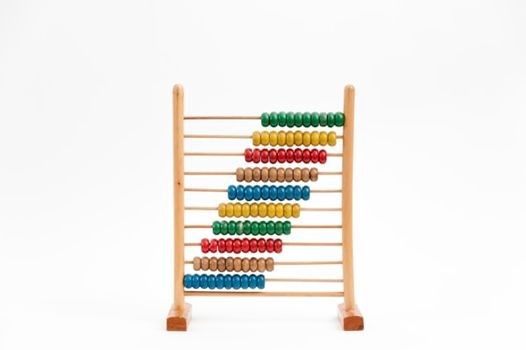

------------------------------ Start of responses ------------------------------


The image shows a wooden abacus with ten rows, each with ten beads. The beads are arranged in a rainbow pattern, with the top row being brown, the second row being red, the third row being orange, the fourth row being yellow, the fifth row being green, the sixth row being light blue, the seventh row being dark blue, the eighth row being purple, the ninth row being pink, and the tenth row being black.

------------------------------- End of responses -------------------------------



In [20]:
prompt = "Describe this image:"
# Image by Crissy Jarvis on Unsplash: https://unsplash.com/photos/cHhbULJbPwM
image_abacus = load_image_from_url(
    "https://unsplash.com/photos/cHhbULJbPwM/download?w=600"
)

contents = [prompt, image_abacus]
responses = generate_content(multimodal_model, contents)

print_contents(contents)
print_responses(responses)

… or ask specific questions:


----------------------------------- Contents -----------------------------------

Answer the following questions about this image.
Return the results as a JSON list containing "question" and "answer" pairs.

QUESTIONS:
- What does the image show?
- How does it work?
- When was it invented?
- What's the name of this object in French, Italian, Spanish, Dutch, and German?
- What are the most prominent colors in the image?



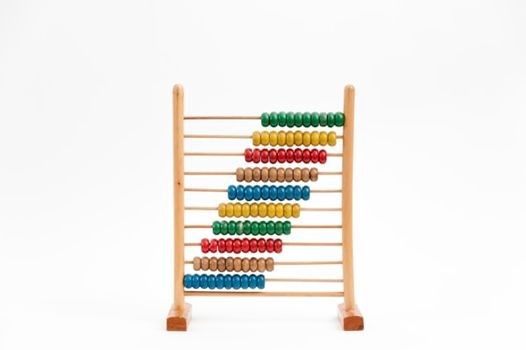

------------------------------ Start of responses ------------------------------


```json
[
  {
    "question": "What does the image show?",
    "answer": "The image shows an abacus."
  },
  {
    "question": "How does it work?",
    "answer": "An abacus is a calculating tool that has been used since ancient times. It is made up of a frame with rows of beads strung on wires. Each bead represents a certain value, and by moving the beads up and down, calculations can be performed."
  },
  {
    "question": "When was it invented?",
    "answer": "The abacus was invented in ancient Mesopotamia around 2700-2300 BC."
  },
  {
    "question": "What's the name of this object in French, Italian, Spanish, Dutch, and German?",
    "answer": "The French word for abacus is boulier, the Italian word is abaco, the Spanish word is \u00e1baco, the Dutch word is rekenrek, and the German word is Rechenbrett."
  },
  {
    "question": "What are the most prominent colors in the image?",
    "answer": "The most prominent colors in the image are red, green, yellow, and blue."
  }
]
```

------------------------------- End of responses -------------------------------



In [21]:
prompt = """
Answer the following questions about this image.
Return the results as a JSON list containing "question" and "answer" pairs.

QUESTIONS:
- What does the image show?
- How does it work?
- When was it invented?
- What's the name of this object in French, Italian, Spanish, Dutch, and German?
- What are the most prominent colors in the image?
"""

contents = [prompt, image_abacus]
responses = generate_content(multimodal_model, contents)

print_contents(contents)
print_responses(responses)

Your specific questions can have follow-up questions:


----------------------------------- Contents -----------------------------------


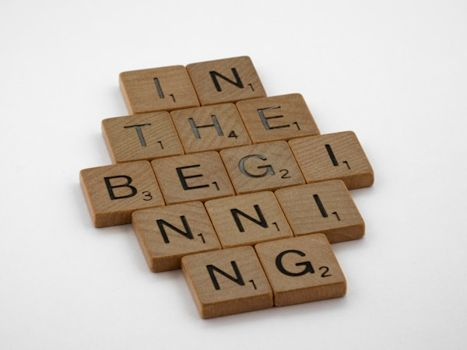


- What expression can be read in this image? How is it presented?
- What is the opposite expression?
- What is a recommendation, starting with this expression, a teacher could give his students for an exam?
- With the opposite expression?

------------------------------ Start of responses ------------------------------


- The expression that can be read in this image is "In the beginning". It is presented using wooden tiles with letters on them.
- The opposite expression is "In the end".
- A recommendation that a teacher could give his students for an exam, starting with the expression "In the beginning", is to start studying early and to prepare well.
- With the opposite expression, the teacher could recommend the students to check their answers at the end of the exam.

------------------------------- End of responses -------------------------------



In [22]:
# Image by Brett Jordan on Unsplash: https://unsplash.com/photos/E1por_SGvJE
image_tiles = load_image_from_url(
    "https://unsplash.com/photos/E1por_SGvJE/download?w=600"
)
prompt = """
- What expression can be read in this image? How is it presented?
- What is the opposite expression?
- What is a recommendation, starting with this expression, a teacher could give his students for an exam?
- With the opposite expression?
"""

contents = [image_tiles, prompt]
responses = generate_content(multimodal_model, contents)

print_contents(contents)
print_responses(responses)

Information can have multiple forms. It can be objects, printed text, handwritten text, and more:


----------------------------------- Contents -----------------------------------

Follow the instructions.
Write math expressions in LaTex.
Use a table with a row for each instruction and its result.

INSTRUCTIONS:
- Extract the formula.
- What is the symbol right before Pi? What does it mean?
- Is this a famous formula? Does it have a name?
- Why is it special?
- Extract the caption.
- What's the object in the bottom?
- What was it used for?
- What colors are the caption and the formula?



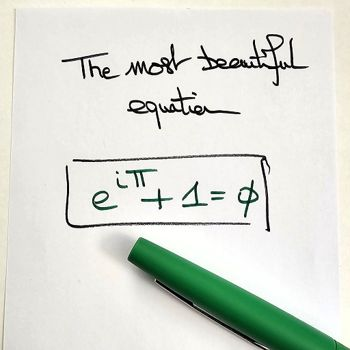

------------------------------ Start of responses ------------------------------


| INSTRUCTION | RESULT |
|:---:|:---:|
| Extract the formula. | $$e^{i\pi}+1=0$$ |
| What is the symbol right before Pi? What does it mean? | i is the imaginary unit, which is a mathematical concept that is used to represent numbers that are not real. |
| Is this a famous formula? Does it have a name? | Yes, it is known as Euler's identity. |
| Why is it special? | It is considered to be one of the most beautiful equations in mathematics because of its simplicity and elegance, and because it relates five fundamental mathematical constants: e, i, π, 1, and 0. |
| Extract the caption. | The most beautiful equation |
| What's the object in the bottom? | A green pen. |
| What was it used for? | The pen was used to write the equation on the paper. |
| What colors are the caption and the formula? | The caption is written in black ink and the formula is written in green ink. |

------------------------------- End of responses -------------------------------



In [23]:
prompt = """
Follow the instructions.
Write math expressions in LaTex.
Use a table with a row for each instruction and its result.

INSTRUCTIONS:
- Extract the formula.
- What is the symbol right before Pi? What does it mean?
- Is this a famous formula? Does it have a name?
- Why is it special?
- Extract the caption.
- What's the object in the bottom?
- What was it used for?
- What colors are the caption and the formula?
"""
image_euler = load_image_from_url(
    "https://storage.googleapis.com/cloud-samples-data/generative-ai/image/math_beauty.jpg"
)

contents = [prompt, image_euler]
responses = generate_content(multimodal_model, contents)

print_contents(contents)
print_responses(responses)

You can also ask for interpretations and suggestions:


In [25]:
# Please like share and subscribe to techcps
# Channel link is here: https://www.youtube.com/@techcps

print("please like share and subscribe to techcps https://www.youtube.com/@techcps")

please like share and subscribe to techcps https://www.youtube.com/@techcps


In [ ]:
prompt = """
Answer the following questions about the image.
Present the results in a table with a row for each question and its answer.

QUESTIONS:
- What is visible?
- What are the reasons it's funny?
- What could be a fun caption?
- What could happen next?
- How would you alter the image? Would it still be funny and why?
- How would you make it funnier?
"""
# Image by Elimende Inagella on Unsplash: https://unsplash.com/photos/4ApmfdVo32Q
image_classroom = load_image_from_url(
    "https://unsplash.com/photos/4ApmfdVo32Q/download?w=600"
)

contents = [prompt, image_classroom]
responses = generate_content(multimodal_model, contents)

print_contents(contents)
print_responses(responses)

### Reasoning on multiple images


You can also use multiple images:


In [ ]:
prompt = f"""
Answer the following questions for each image.
Present the results in a table with a row for each image and a column for each question.

QUESTIONS:
- What can we see in the image?
- Where does it take place?
"""
caption_b1 = "Image 1:"
caption_b2 = "Image 2:"
caption_b3 = "Image 3:"
# Photo by Deleece Cook on Unsplash: https://unsplash.com/photos/zzjLGF_6dx4
image_b1 = load_image_from_url("https://unsplash.com/photos/zzjLGF_6dx4/download?w=600")
# Photo by Natasha Kapur on Unsplash: https://unsplash.com/photos/ndAHi2Wxcok
image_b2 = load_image_from_url("https://unsplash.com/photos/ndAHi2Wxcok/download?w=600")
# Photo by Roman Mager on Unsplash: https://unsplash.com/photos/5mZ_M06Fc9g
image_b3 = load_image_from_url("https://unsplash.com/photos/5mZ_M06Fc9g/download?w=600")

contents = [prompt, caption_b1, image_b1, caption_b2, image_b2, caption_b3, image_b3]
responses = generate_content(multimodal_model, contents)

print_contents(contents)
print_responses(responses)

… or make comparisons between images:


In [ ]:
prompt = """
Answer the following questions about the images, with a short answer and a detailed reason for the answer.
Present the results in a table with a row for each question, answer, and reason.

QUESTIONS:
- What do the images have in common?
- Which one would be of interest to a mathematician?
- Which one indicates it's the end of vacation?
- Which one suggests we may get a coffee there?
"""

contents = [prompt, caption_b1, image_b1, caption_b2, image_b2, caption_b3, image_b3]
responses = generate_content(multimodal_model, contents)

print_contents(contents)
print_responses(responses)

You can use Gemini's level of language and visual understanding to work with concepts or even get suggestions on new images:


In [ ]:
prompt = """
Answer the following questions about the images, with a short answer and a detailed reason for the answer.
Present the results in a table with a row for each question, answer, and reason.

QUESTIONS:
- What does the first image represent?
- What does the second image represent?
- What could be a next logical image?
"""
caption_w1 = "Image 1:"
caption_w2 = "Image 2:"
# Photo by Diego Ballon Vargas on Unsplash: https://unsplash.com/photos/TA5bUTySOrg
image_w1 = load_image_from_url("https://unsplash.com/photos/TA5bUTySOrg/download?w=600")
# Photo by Reza Shayestehpour on Unsplash: https://unsplash.com/photos/Nw_D8v79PM4
image_w2 = load_image_from_url("https://unsplash.com/photos/Nw_D8v79PM4/download?w=600")

contents = [prompt, caption_w1, image_w1, caption_w2, image_w2]
responses = generate_content(multimodal_model, contents)

print_contents(contents)
print_responses(responses)

This is really up to your imagination:


In [ ]:
prompt = """
Answer the following questions, with a short answer and a detailed reason for the answer.
Present the results in a table with a row for each question, answer, and reason.

QUESTIONS:
- What theme do these images illustrate?
- What could be another image to replace the first one?
- What other image could replace the second one?
- What would be an alternative to the third image?
- And for the last one?
"""
caption_s1 = "Image 1:"
caption_s2 = "Image 2:"
caption_s3 = "Image 3:"
caption_s4 = "Image 4:"
# Photo by Tomoko Uji on Unsplash: https://unsplash.com/photos/eriuKJwcdjI
image_s1 = load_image_from_url("https://unsplash.com/photos/eriuKJwcdjI/download?w=600")
# Photo by Todd Trapani on Unsplash: https://unsplash.com/photos/QldMpmrmWuc
image_s2 = load_image_from_url("https://unsplash.com/photos/QldMpmrmWuc/download?w=600")
# Photo by Olivia Hutcherson on Unsplash: https://unsplash.com/photos/rN3m7aTH3io
image_s3 = load_image_from_url("https://unsplash.com/photos/rN3m7aTH3io/download?w=600")
# Photo by Eberhard Grossgasteiger on Unsplash: https://unsplash.com/photos/FhdN5QVrBfY
image_s4 = load_image_from_url("https://unsplash.com/photos/FhdN5QVrBfY/download?w=600")

contents = [
    prompt,
    caption_s1,
    image_s1,
    caption_s2,
    image_s2,
    caption_s3,
    image_s3,
    caption_s4,
    image_s4,
]
responses = generate_content(multimodal_model, contents)

print_contents(contents)
print_responses(responses)

### Reasoning on a video


And you also can extract information from a video:


In [ ]:
prompt = """
Answer the following questions using the video only.
Present the results in a table with a row for each question and its answer.

QUESTIONS:
- What is the main animal visible throughout the video?
- Which electronic devices are visible?
- What animals are the cartoon characters doing a close-up selfie?
- Which famous brands are visible?
- What is the text visible at the end?
"""
video = Part.from_uri(
    uri="gs://cloud-samples-data/video/animals.mp4",
    mime_type="video/mp4",
)

contents = [prompt, video]
responses = generate_content(multimodal_model, contents)

print_contents(contents)
print_responses(responses)

## Conclusion

In this tutorial, you saw examples of how you can use Gemini for education and benefit from text and multimodal models to generate content from text, images, and videos.

You may also want to explore other tutorials that focus on different domains or specificities of the Vertex AI Gemini API.
